1) parameters tune

2) learning curve

3) является ли предыдущая строка продолжением следующей - сделать лучше + тесты


In [1]:
import re
import cv2
import json
import numpy as np
from functools import reduce
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import xgbfir
from itertools import product
from sklearn.utils import shuffle

In [2]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1 1
            re.compile(r'\d+[\)\}]'), # 1) 2
            re.compile(r'\w+(\.\w+)+\W'), # 3
            re.compile(r'[а-яА-Я\d]+(\.[а-яА-Я\d]+)+\W'), # b.b.b 4
            re.compile(r'[\wа-яА-Я]\.\W'), # b. 5
            re.compile(r'[6а-яА-Яa-zA-Z][\)\}]'), # б) 6
            re.compile(r'\-|—'), # - 7
            re.compile(r'®|\*'), # * 8
            re.compile(r'[a-zа-я]'), # строчная буква в начале 9
            re.compile(r'[A-ZА-Я]'),  # заглавная буква в начале 10
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья'), # 11 
            re.compile(r'[\wа-я] ')] # 12

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
        i += 1
        
    return features

In [3]:
end_reg_expr = [re.compile(r'.*\.'),
                re.compile(r'.*;'),
                re.compile(r'.*:'),
                re.compile(r'.*,'),
                re.compile(r'.*[\wа-яА-Я]'),
                re.compile(r'[А-ЯA-Z\.,\s]+')] # uppercase

def add_end_reg_features(line):
    features = [0] * len(end_reg_expr)
    i = 0
    for expr in end_reg_expr:
        match = expr.fullmatch(line)
        if match:
            features[i] = 1
        i += 1
    return features

In [4]:
# 1.1.1 -> 1.1.2
# 1) -> 2)
# 1. -> 2.
# -

# unit tests!!!
# analyzing previous lines

RE_LIST1 = re.compile(r'\d+(\.\d+)+\D') # 1.1.1
RE_LIST2 = re.compile(r'\d+[\)\.]\s') # 1) 1.
RE_LIST3 = re.compile(r'\-|—') # -
RE_LIST4 = re.compile(r'[a-zA-Zа-яА-Я][\)\.]\s') # a)

def list_continue(doc_info, line, line_num):
    match = RE_LIST1.match(line)
    if match:
        last_num = int(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == int(match.group()[-2]) + 1
        return False
    match = RE_LIST2.match(line)
    if match:
        last_num = int(match.group()[:-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST2.match(doc_line)
            if match:
                return last_num == int(match.group()[:-2]) + 1
        return False
    match = RE_LIST3.match(line)
    if match:
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST3.match(doc_line)
            if match:
                return True
        return False
    match = RE_LIST4.match(line)
    if match:
        last_num = ord(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == ord(match.group()[-2]) + 1
        return False
    return False

In [5]:
# font-weight detection

def bold_mean_color(bbox, img, d_ksize, e_ksize):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    kernel = np.ones((d_ksize, d_ksize),np.uint8)
    dilation = cv2.dilate(crop_img, kernel, iterations = 1)
    kernel = np.ones((e_ksize, e_ksize),np.uint8)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    avg_color_per_row = np.average(erosion, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [6]:
# amount letters of the first word in line

RE_WORD = re.compile(r'[a-zA-Zа-яА-Я]+')
RE_FIRST = re.compile(r'\S+\s')

def letters_cnt(line):
    res = [0, 0, 0]
    match = RE_WORD.search(line)
    if match:
        if match.start() == 0: # word in the beginning of the line
            res[0] = len(match.group(0))
    match = RE_FIRST.search(line)
    if match:
        if match.start() == 0: # some characters in the beginning of the line
            res[1] = len(match.group(0))
    words = line.split()
    if len(words) >= 2:
        res[2] = len(words[1])
    return res

In [7]:
def add_bold_mean_colors(bbox, img, num):
    res = []
    for i in range(2, num + 1):
        res.append(bold_mean_color(bbox, img, i, i ))
    return res

In [8]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            num_bold = 7
            img = cv2.imread('docs/' + doc_name)
            heigth = img.shape[0]
            width = img.shape[1]
            i = 0
            for line_info in doc_info:
                list_cont = list_continue(doc_info, line_info['text'], i) # several different features???
                word_cnt = len(line_info['text'].split())
                line_length = len(line_info['text'])
                
                line_features = [line_info['bbox'][0] / width, # left
                                 line_info['bbox'][1] / heigth, # top
                                 line_info['bbox'][3] / heigth, # height
                                 line_length, word_cnt, list_cont] 
                line_features += add_bold_mean_colors(line_info['bbox'], img, num_bold)
                line_features += add_reg_features(line_info['text'])
                line_features += add_end_reg_features(line_info['text'])
                line_features += letters_cnt(line_info['text'])
                doc_features.append(line_features)
                i += 1
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [9]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [10]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            l = len(doc_features)
            mean_left = np.sum(list(map(lambda x: x[0], doc_features))) / l
            mean_heigth = np.sum(list(map(lambda x: x[2], doc_features))) / l
            mean_line_length = np.sum(list(map(lambda x: x[3], doc_features))) / l
            mean_bold_color = np.sum(list(map(lambda x: x[9], doc_features))) / l # bold5
            # mean word letters cnt, mean word cnt
            for line_features in doc_features:
                new_features = add_prev_next_features(doc_features, line_features, i)
                i += 1
                new_features += [mean_left, mean_heigth, mean_line_length, mean_bold_color]
                result.append(new_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [19]:
label2class = {
    "header" : 1,
    "list" : 2,
    "text" : 3,
    "other" : 4
}

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [label2class[line['label']] for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

In [20]:
import random

feature_extractor = make_pipeline(AddImgFeatures(),
                                  AddPrevNextFeatures())
scores = [] # (train_cnt, score)
train_num = list(range(500, 10, -30))

for train_cnt in tqdm(train_num):
    xgb_cmodel = XGBClassifier(nthread=4)
    X, y = X, y = shuffle(X, y, random_state=random.randint(0, 10000))
    X_train, X_test = X[:train_cnt], X[train_cnt:]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:train_cnt]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[train_cnt:]))

    X_train = feature_extractor.fit_transform(X_train)
    X_test = feature_extractor.fit_transform(X_test)

    xgb_cmodel.fit(X_train, y_train)

    y_pred = xgb_cmodel.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print(train_cnt, score)
    scores.append((train_cnt, score))

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


500 0.9828692863817787
470 0.9832295229265453
440 0.9922879193122149
410 0.9900398457916189
380 0.9909711119891198
350 0.9919440085595874
320 0.9946355242569584
290 0.9869059268013066
260 0.7382445621805155
230 0.9031277691422606
200 0.7402836801100733
170 0.729278580129781
140 0.9807447787494398
110 0.7304543455642163
80 0.7221454008801009
50 0.8138620524086274
20 0.6495354027091951



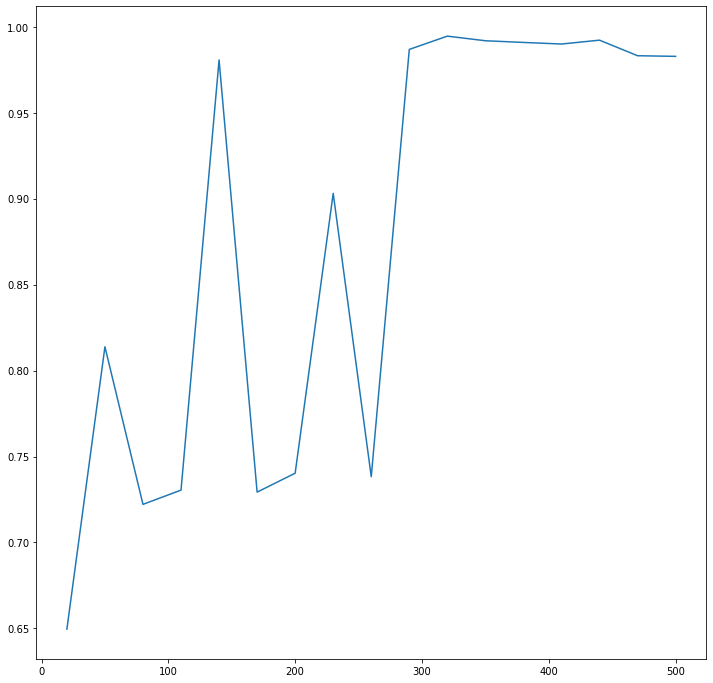

In [21]:
plt.figure(figsize=(12, 12))
plt.plot(train_num, list(map(lambda x: x[1],scores)))

In [ ]:
feature_extractor = make_pipeline(AddImgFeatures(),
                                  AddPrevNextFeatures())
xgb_cmodel = XGBClassifier()

X, y = shuffle(X, y, random_state=1)
X_train, X_test = X[:400], X[400:]
y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:400]))
y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[400:]))

X_train = feature_extractor.fit_transform(X_train)
X_test = feature_extractor.fit_transform(X_test)

xgb_cmodel.fit(X_train, y_train)

y_pred = xgb_cmodel.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
score

In [ ]:
def get_feature_names(names):
    feature_names = names.copy()
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_prev_' + name)
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_next_' + name)
    return feature_names

In [ ]:
feature_names = get_feature_names(['left', 'top', 'height',
                                   'line_length', 'word_cnt', 'list_cont',
                                   'bold2', 'bold3', 'bold4', 'bold5', 'bold6', 'bold7',
                                   'reg1', 'reg2','reg3', 'reg4', 'reg5', 'reg6', 
                                   'reg7', 'reg8', 'reg9', 'reg10', 'reg11', 'reg12',
                                   'end_reg1', 'end_reg2', 'end_reg3', 
                                   'end_reg4', 'end_reg5', 'uppercase',
                                   'word_letters_cnt', 'first_cnt', 'second_cnt'])

feature_names += ['mean_left', 'mean_height', 'mean_line_length', 'mean_bold_color']

xgbfir.saveXgbFI(xgb_cmodel, feature_names=feature_names, 
                 OutputXlsxFile='fearures_importances.xlsx')

X_test [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]

In [ ]:
X_train, X_test = X[:400], X[400:]

d = {}
i = 0
for doc_info in X_test:
    for line_info in doc_info['entities']:
        d[(tuple(line_info['bbox']), doc_info['name'], 
           line_info["text"])] = [y_test[i], y_pred[i]]
        i += 1

In [ ]:
color_dict = {
    1 : (0, 0, 255),
    2 : (0, 255, 0),
    3 : (255, 0, 0),
    4 : (0, 255, 255)
}
class2label = {
    1: "header", 
    2: "list", 
    3: "text", 
    4: "other"
}

grouped_by_dock = defaultdict(list)
for item in d.items():
    key, (real_class, predicted_class) = item
    file_name = key[1]
    grouped_by_dock[file_name].append(item)


for file_name, items in tqdm(grouped_by_dock.items()):
    
    img = None 
    for key, (real_class, predicted_class) in items:        
        if real_class != predicted_class:
            print(key[2])
            print()
            if img is None:
                img = cv2.imread('docs/' + file_name)
            (x, y, w, h) = key[0]
            cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[predicted_class], 2)
            cv2.putText(img, class2label[predicted_class] + 
                        " " + class2label[real_class], 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                        color_dict[predicted_class], 2)
    if img is not None:
        cv2.imwrite('different_docs/' + file_name, img)        